In [47]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())


Saving pedidos.csv to pedidos (1).csv
Saving edges.csv to edges (1).csv
Saving nodes.csv to nodes (1).csv


['pedidos (1).csv', 'edges (1).csv', 'nodes (1).csv']

In [94]:
!pip -q install networkx pandas matplotlib

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import math
import io
from sklearn.cluster import KMeans


In [49]:
# 3) Ler CSVs (assumindo os nomes corretos)

nodes = pd.read_csv(io.BytesIO(uploaded['nodes.csv'])) if 'nodes.csv' in uploaded else pd.read_csv('nodes.csv')
edges = pd.read_csv(io.BytesIO(uploaded['edges.csv'])) if 'edges.csv' in uploaded else pd.read_csv('edges.csv')

In [50]:
# 4) Montar o grafo (usando TEMPO como peso principal, distancia_km)

G = nx.Graph()

for _, r in nodes.iterrows():
    node_id = int(r['id'])
    G.add_node(node_id, nome=r['nome'], lat=float(r['lat']), lon=float(r['lon']))

for _, r in edges.iterrows():
    o = int(r['origem']); d = int(r['destino'])
    dist = float(r['distancia_km'])
    tempo = float(r['tempo_min'])
    G.add_edge(o, d, distancia_km=dist, tempo_min=tempo)

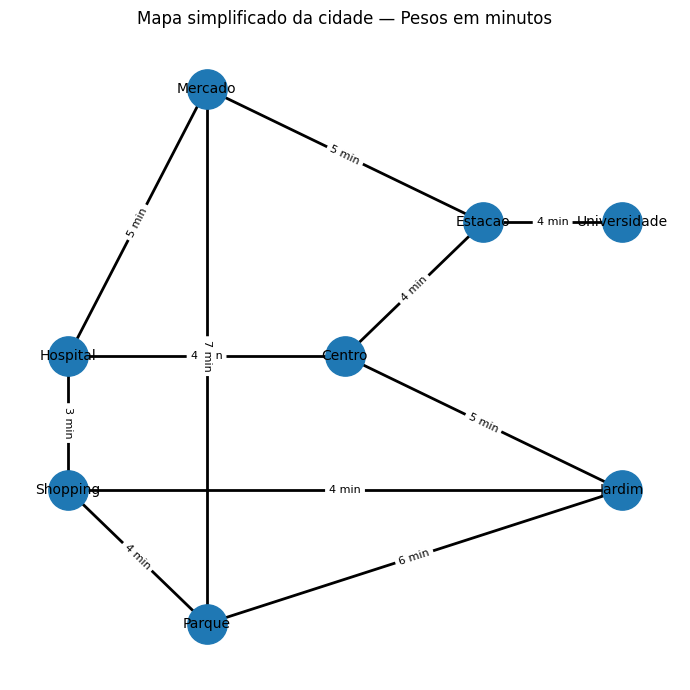

Nós (lugares): 8
Arestas (ruas): 11


In [142]:
# 5) Preparar posições (x = lon, y = lat)

pos = {n: (G.nodes[n]['lon'], G.nodes[n]['lat']) for n in G.nodes}
labels_nos = {n: G.nodes[n]['nome'] for n in G.nodes}
labels_arestas = {(u, v): f"{G[u][v]['tempo_min']:.0f} min" for u, v in G.edges}

# 6) Grafo

plt.figure(figsize=(7,7))
nx.draw_networkx_nodes(G, pos, node_size=800)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, labels=labels_nos, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_arestas, font_size=8)

plt.title("Mapa simplificado da cidade — Pesos em minutos")
plt.axis('off')
plt.tight_layout()
plt.savefig("grafo.png", dpi=200, bbox_inches="tight")
plt.show()

# 7) Conferências rápidas

print(f"Nós (lugares): {G.number_of_nodes()}")
print(f"Arestas (ruas): {G.number_of_edges()}")

In [54]:
# 8) Baixar a imagem

try:
    files.download("grafo.png")
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
G = nx.Graph()
for _, r in nodes.iterrows():
    G.add_node(int(r['id']), nome=str(r['nome']), lat=float(r['lat']), lon=float(r['lon']))
for _, r in edges.iterrows():
    G.add_edge(int(r['origem']), int(r['destino']),
               distancia_km=float(r['distancia_km']),
               tempo_min=float(r['tempo_min']))

In [77]:
# 2) Nomes válidos

nomes_validos = sorted([G.nodes[n]['nome'] for n in G.nodes])
print("Lugares disponíveis:", nomes_validos)

Lugares disponíveis: ['Centro', 'Estacao', 'Hospital', 'Jardim', 'Mercado', 'Parque', 'Shopping', 'Universidade']


In [87]:
origem_nome = "Centro"
paradas     = ["Mercado", "Estacao", "Parque"]

# 4) A*: distância em linha reta (haversine) convertida para minutos

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = math.radians(lat2 - lat1); dlon = math.radians(lat2 - lon2)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))

min_per_km = edges['tempo_min'].sum() / max(edges['distancia_km'].sum(), 1e-9)
def heuristica_min(n1, n2):
    a, b = G.nodes[n1], G.nodes[n2]
    km = haversine_km(a['lat'], a['lon'], b['lat'], b['lon'])
    return km * min_per_km

def a_estrela(u, v):
    return nx.astar_path(G, u, v, heuristic=heuristica_min, weight='tempo_min')
    nome2id = {G.nodes[n]['nome']: n for n in G.nodes}
assert origem_nome in nome2id, f"Origem '{origem_nome}' não existe. Use um dos nomes acima."
for nm in paradas:
    assert nm in nome2id, f"Parada '{nm}' não existe. Use um dos nomes acima."

ordem_nomes = [origem_nome] + paradas
ordem_ids   = [nome2id[nm] for nm in ordem_nomes]


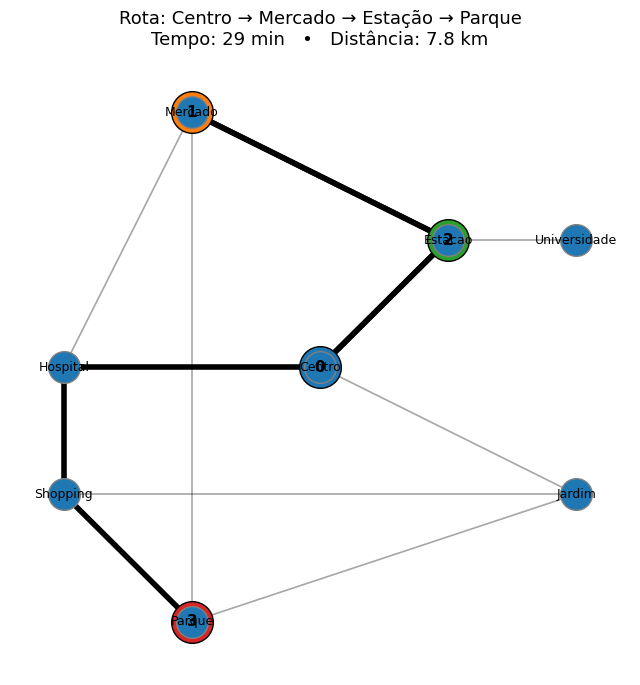

In [143]:
# 6) Rota multipontos concatenando menores caminhos A*

rota_total = []
for u, v in zip(ordem_ids, ordem_ids[1:]):
    seg = a_estrela(u, v)
    rota_total += seg[1:] if (rota_total and seg and seg[0] == rota_total[-1]) else seg

# 7) Métricas

def soma_attr(caminho, attr):
    return sum(G[u][v][attr] for u, v in zip(caminho[:-1], caminho[1:]))
tempo_total = soma_attr(rota_total, 'tempo_min')
dist_total  = soma_attr(rota_total, 'distancia_km')

pos    = {n: (G.nodes[n]['lon'], G.nodes[n]['lat']) for n in G.nodes}
labels = {n: G.nodes[n]['nome'] for n in G.nodes}
arestas_rota = list(zip(rota_total[:-1], rota_total[1:]))

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.35)
nx.draw_networkx_nodes(G, pos, node_size=520, edgecolors='gray')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
nx.draw_networkx_edges(G, pos, edgelist=arestas_rota, width=4)

for idx, nm in enumerate(ordem_nomes):
    nid = nome2id[nm]; x, y = pos[nid]
    plt.scatter([x],[y], s=900, edgecolor='black')
    plt.text(x, y, str(idx), fontsize=11, ha='center', va='center', weight='bold')

rota_txt = " → ".join(ordem_nomes).replace("Estacao","Estação")
plt.title(f"Rota: {rota_txt}\nTempo: {tempo_total:.0f} min   •   Distância: {dist_total:.1f} km",
          fontsize=13, pad=10)
plt.axis('off')
os.makedirs('docs', exist_ok=True)
plt.savefig('docs/rota_multiplos_pontos.png', dpi=220, bbox_inches='tight')
plt.show()

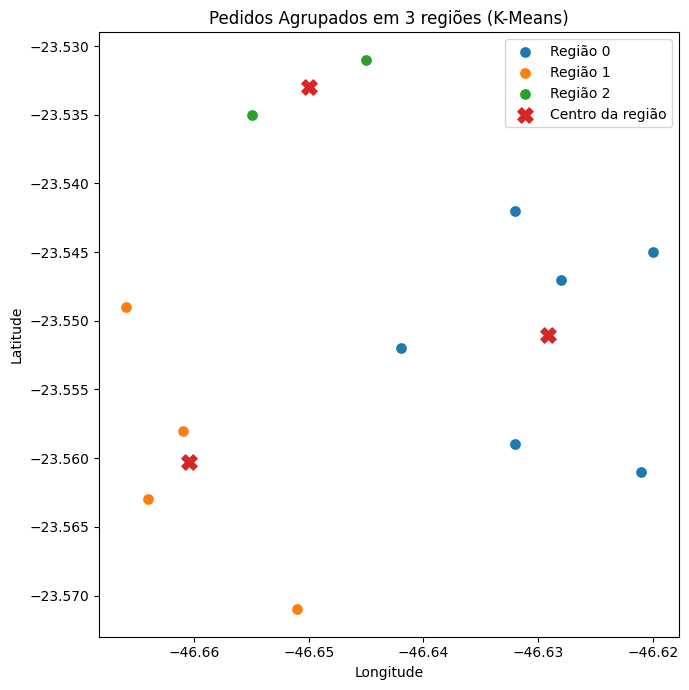

TOTAL de pedidos: 12  |  Nº de regiões (k): 3

Região 0: 6 pedidos (50.0%)  •  Centro ~ (lat -23.5510, lon -46.6292)
Região 1: 4 pedidos (33.3%)  •  Centro ~ (lat -23.5602, lon -46.6605)
Região 2: 2 pedidos (16.7%)  •  Centro ~ (lat -23.5330, lon -46.6500)


In [144]:
# 1) Carregar pedidos (id, lat, lon)

pedidos = pd.read_csv('pedidos.csv')

# 2) Número de regiões/entregadores (k)
k = 3

# 3) Rodar K-Means
km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = km.fit_predict(pedidos[['lat','lon']].values)
pedidos['cluster'] = labels
centroids = km.cluster_centers_

# 4) Plot dos clusters

plt.figure(figsize=(7,7))
for c in range(k):
    sub = pedidos[pedidos['cluster'] == c]
    plt.scatter(sub['lon'], sub['lat'], s=45, label=f'Região {c}')

plt.scatter(centroids[:,1], centroids[:,0], marker='X', s=120, label='Centro da região')

plt.title(f'Pedidos Agrupados em {k} regiões (K-Means)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.legend(); plt.tight_layout()

os.makedirs('docs', exist_ok=True)
plt.savefig('docs/clusters.png', dpi=200, bbox_inches='tight')
plt.show()

# 5) Salvar CSV com o cluster de cada pedido

os.makedirs('data', exist_ok=True)
pedidos.to_csv('data/pedidos_clusterizados.csv', index=False, encoding='utf-8')

total = len(pedidos)
contagem = pedidos['cluster'].value_counts().sort_index()

print(f"TOTAL de Pedidos: {total}  |  Nº de Regiões (k): {k}\n")

for c in range(k):
    qtd = int(contagem.get(c, 0))
    pct = (qtd / total * 100) if total else 0
    lat, lon = centroids[c]
    print(f"Região {c}: {qtd} pedidos ({pct:.1f}%)  •  Centro ~ (lat {lat:.4f}, lon {lon:.4f})")




In [139]:
os.makedirs("docs", exist_ok=True)
plt.savefig("docs/grafo.png", dpi=200, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

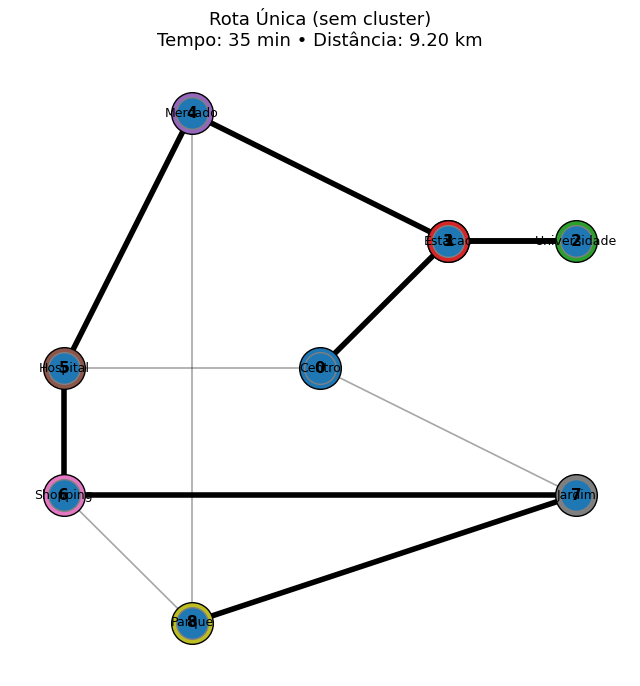

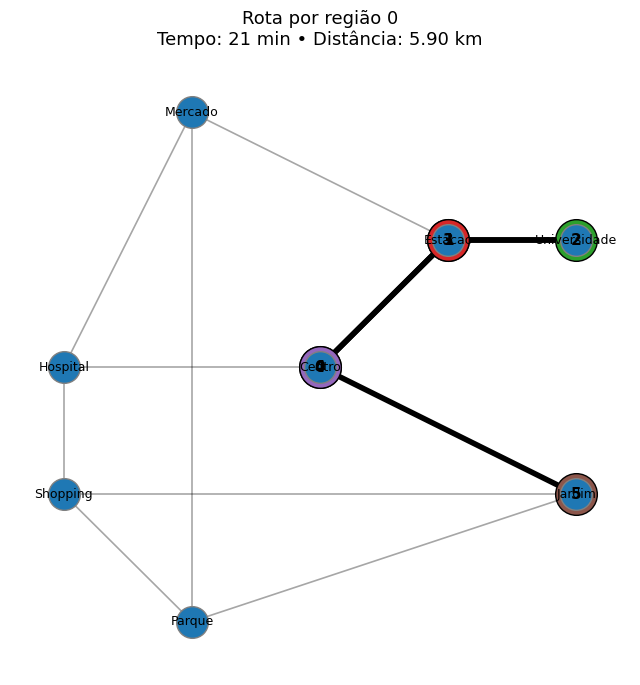

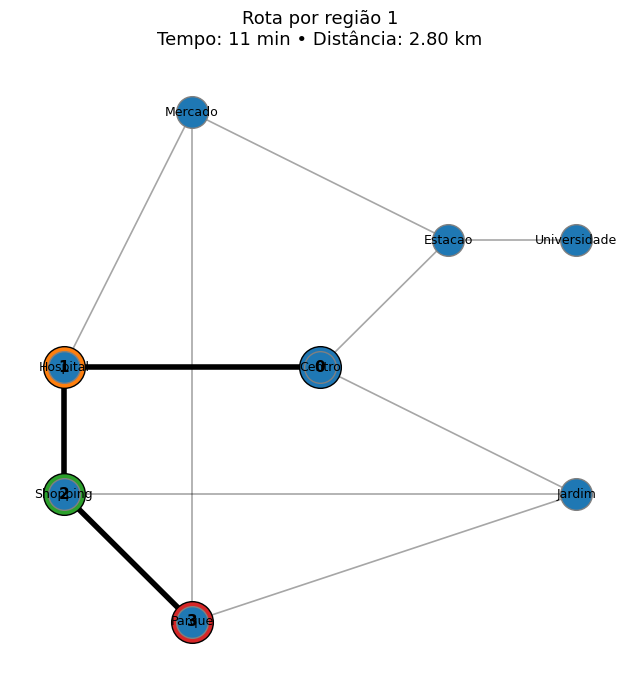

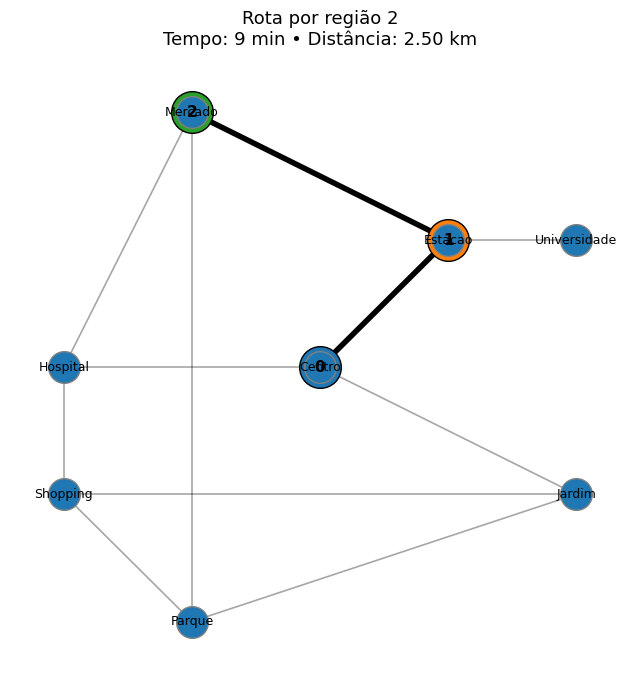

In [108]:
ORIGEM = "Centro"
assert ORIGEM in nome2id, f"Origem '{ORIGEM}' não existe nos nós."

# 4) A* (heurística em minutos)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))

min_per_km = edges['tempo_min'].sum() / max(edges['distancia_km'].sum(), 1e-9)
def hmin(n1, n2):
    a, b = G.nodes[n1], G.nodes[n2]
    return haversine_km(a['lat'], a['lon'], b['lat'], b['lon']) * min_per_km

def a_star(u, v):
    return nx.astar_path(G, u, v, heuristic=hmin, weight='tempo_min')

def custo(caminho, attr):
    return sum(G[u][v][attr] for u, v in zip(caminho[:-1], caminho[1:]))

# 5) Utilidades: nó mais próximo e rota por Vizinho Mais Próximo (NN)
def no_mais_proximo(lat, lon):
    best, dmin = None, float('inf')
    for n in G.nodes:
        d = haversine_km(lat, lon, G.nodes[n]['lat'], G.nodes[n]['lon'])
        if d < dmin: best, dmin = n, d
    return best

def rota_nn(origem_id, destinos_ids):
    ordem = [origem_id]
    restantes = destinos_ids[:]
    atual = origem_id
    while restantes:
        prox, melhor = None, float('inf')
        for cand in restantes:
            cam = a_star(atual, cand)
            t = custo(cam, 'tempo_min')
            if t < melhor: prox, melhor = cand, t
        ordem.append(prox); restantes.remove(prox); atual = prox

    rota = []
    for u, v in zip(ordem, ordem[1:]):
        seg = a_star(u, v)
        rota += seg[1:] if (rota and seg and seg[0]==rota[-1]) else seg
    return rota, custo(rota,'tempo_min'), custo(rota,'distancia_km')

# 6) Plot simples de uma rota
def plot_rota(rota, titulo, fname):
    pos = {n:(G.nodes[n]['lon'], G.nodes[n]['lat']) for n in G.nodes}
    labels = {n:G.nodes[n]['nome'] for n in G.nodes}
    plt.figure(figsize=(8,8))
    nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.35)
    nx.draw_networkx_nodes(G, pos, node_size=520, edgecolors='gray')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
    nx.draw_networkx_edges(G, pos, edgelist=list(zip(rota[:-1], rota[1:])), width=4)
    ordem = [rota[0]]
    for n in rota[1:]:
        if n != ordem[-1]: ordem.append(n)
    for i, nid in enumerate(ordem):
        x,y = pos[nid]
        plt.scatter([x],[y], s=900, edgecolor='black')
        plt.text(x, y, str(i), fontsize=11, ha='center', va='center', weight='bold')
    plt.title(titulo, fontsize=13, pad=10)
    plt.axis('off')
    os.makedirs('docs', exist_ok=True)
    plt.savefig(f'docs/{fname}', dpi=220, bbox_inches='tight')
    plt.show()

# 7) (A) SEM CLUSTER: todos os pedidos juntos
orig_id = nome2id[ORIGEM]
dest_todos = [no_mais_proximo(r.lat, r.lon) for _, r in pedclu.iterrows()]
dest_todos = list(dict.fromkeys(dest_todos))
rota_sem, t_sem, d_sem = rota_nn(orig_id, dest_todos)
plot_rota(rota_sem, f"Rota Única (sem cluster)\nTempo: {t_sem:.0f} min • Distância: {d_sem:.2f} km",
          "rota_sem_cluster.png")

# 8) (B) COM CLUSTER: uma rota por região e soma total
t_com, d_com = 0.0, 0.0
resumo = []
for c in sorted(pedclu['cluster'].unique()):
    sub = pedclu[pedclu['cluster']==c]
    destinos = [no_mais_proximo(r.lat, r.lon) for _, r in sub.iterrows()]
    destinos = list(dict.fromkeys(destinos))
    if not destinos: continue
    rota_c, t_c, d_c = rota_nn(orig_id, destinos)
    t_com += t_c; d_com += d_c
    resumo.append((int(c), len(sub), t_c, d_c))
    plot_rota(rota_c, f"Rota por região {c}\nTempo: {t_c:.0f} min • Distância: {d_c:.2f} km",
              f"rota_regiao_{c}.png")


In [136]:
cab1 = ["CENÁRIO", "TEMPO", "DISTÂNCIA", "VARIAÇÃO DE TEMPO", "VARIAÇÃO DE DISTÂNCIA"]
lin1 = [
    ["Sem cluster",         fmt_min(t_sem), fmt_km(d_sem), "—",            "—"],
    ["Com cluster (soma)",  fmt_min(t_com), fmt_km(d_com), fmt_pct(ganho_t), fmt_pct(ganho_d)],
]

larguras = [max(len(str(x)) for x in col) for col in zip(cab1, *lin1)]
def linha_formatada(campos):
    return " | ".join(str(c).ljust(w) for c, w in zip(campos, larguras))
print("\n=== COMPARAÇÃO (Sem × Com cluster) ===")
print(linha_formatada(cab1))
print("-" * (sum(larguras) + 3*(len(cab1)-1)))
for L in lin1:
    print(linha_formatada(L))

cab2 = ["REGIÃO", "PEDIDOS", "TEMPO", "DISTÂNCIA"]
lin2 = []
for (c, n, t, d) in sorted(resumo, key=lambda x: x[0]):
    lin2.append([f"Região {c}", str(n), fmt_min(t), fmt_km(d)])

larguras2 = [max(len(str(x)) for x in col) for col in zip(cab2, *lin2)]
def linha_formatada2(campos):
    return " | ".join(str(c).ljust(w) for c, w in zip(campos, larguras2))
print("\n== POR REGIÃO ==\n")
print(linha_formatada2(cab2))
print("-" * (sum(larguras2) + 3*(len(cab2)-1)))
for L in lin2:
    print(linha_formatada2(L))

os.makedirs("docs", exist_ok=True)
df_comp = pd.DataFrame({
    "Cenário": ["Sem cluster", "Com cluster (soma)"],
    "Tempo (min)": [round(t_sem,1), round(t_com,1)],
    "Distância (km)": [round(d_sem,2), round(d_com,2)],
    "Variação Tempo (%) vs. Sem": [0.0, round(ganho_t,1)],
    "Variação Distância (%) vs. Sem": [0.0, round(ganho_d,1)],
})
df_reg = pd.DataFrame([{"Região": f"Região {c}", "Pedidos": n, "Tempo (min)": round(t,1), "Distância (km)": round(d,2)}
                       for (c, n, t, d) in sorted(resumo, key=lambda x: x[0])])



=== COMPARAÇÃO (Sem × Com cluster) ===
CENÁRIO            | TEMPO    | DISTÂNCIA | VARIAÇÃO DE TEMPO | VARIAÇÃO DE DISTÂNCIA
-------------------------------------------------------------------------------------
Sem cluster        | 35,0 min | 9,20 km   | —                 | —                    
Com cluster (soma) | 41,0 min | 11,20 km  | -17,1%            | -21,7%               

== POR REGIÃO ==

REGIÃO   | PEDIDOS | TEMPO    | DISTÂNCIA
-----------------------------------------
Região 0 | 6       | 21,0 min | 5,90 km  
Região 1 | 4       | 11,0 min | 2,80 km  
Região 2 | 2       | 9,0 min  | 2,50 km  
